In [2]:
import numpy as np
from qutip import *
import dask
import pandas as pd
from dask import delayed
import dask.bag as db
import dask.array as da
from dask.distributed import Client, LocalCluster,progress
# from tqdm import tqdm
import importlib
import functions_fbq
importlib.reload(functions_fbq)
from functions_fbq import *
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from figurestyle import *
figure_features()

In [3]:
cluster = LocalCluster(n_workers=20, threads_per_worker=1)
client = Client(cluster)

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:49516
INFO:distributed.scheduler:  dashboard at:            127.0.0.1:8787
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:49524'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:49525'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:49526'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:49527'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:49528'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:49529'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:49530'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:49531'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:49538'
INFO:distributed.nanny:        St

In [4]:
Ec = 40e9
EDelta = 20e9
eigvals = 2
phi_ext = np.pi

El_list = np.logspace(np.log10(10e6), np.log10(50e9), 100)
r_list = np.linspace(0.01, 0.99, 100)
El_r_pairs = [(El,r) for El in El_list for r in r_list]
fermionic_fidelity_matrix = np.zeros((len(El_list), len(r_list)))

In [5]:
@delayed
def fermionic_fidelity_function(El,r):
    _,ekets = eigensystem_fbq(Ec, El, EDelta, phi_ext, r, N = 100, eigvals = 2)
    rho_0 = (ekets[0]*ekets[0].dag()).ptrace(0)
    rho_1 = (ekets[1]*ekets[1].dag()).ptrace(0)
    return (((rho_0.sqrtm()*rho_1*rho_0.sqrtm()).sqrtm()).tr())**2


In [6]:
# Crear un dask bag a partir de la lista de tuplas y mapear la función process_r
results_bag = db.from_sequence(El_r_pairs).map(lambda x: fermionic_fidelity_function(x[0], x[1]))

# Calcular los resultados
computed_results = dask.compute(*results_bag)

# Asignar los resultados a las matrices correspondientes
k = 0
for i, El in enumerate(El_list):
        for j, r in enumerate(r_list):
                fermionic_fidelity_matrix[i,j] = computed_results[k]
        k += 1

In [30]:
El_mesh, r_mesh = np.meshgrid(El_list, r_list, indexing="ij")

El_flat = El_mesh.flatten()
r_flat = r_mesh.flatten()
fidelity_flat = fermionic_fidelity_matrix.flatten()

data = {'El': El_flat, 'r': r_flat, 'Fidelidad': fidelity_flat}
df = pd.DataFrame(data)

filename = f'fermionic_fidelity_Ec_{Ec*1e-9:.0f}_Delta_{EDelta*1e-9:.0f}_phi_ext_{phi_ext:.2f}.csv'
df.to_csv(filename, index=False)

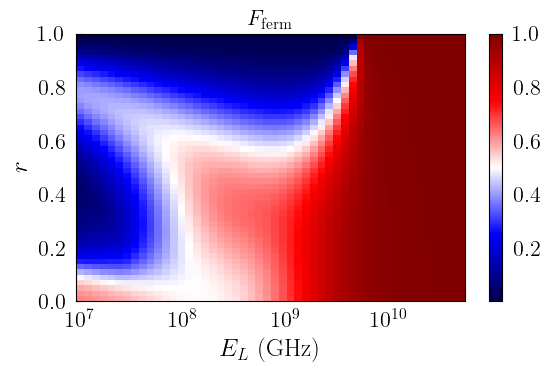

In [35]:
fig, ax = plt.subplots(figsize=(6, 4))
fid = ax.pcolormesh(El_mesh, r_mesh, np.abs(fermionic_fidelity_matrix), cmap='seismic')
ax.set_xscale('log')
ax.set_xlabel(r'$E_L$ (GHz)')
ax.set_ylabel(r'$r$')
ax.set_title(r'$F_{\rm ferm}$')
fig.colorbar(fid, ax=ax)
fig.tight_layout()
fig.savefig(f'figures/fermionic_fidelity_Ec_{Ec*1e-9:.0f}_Delta_{EDelta*1e-9:.0f}_phi_ext_{phi_ext:.2f}.pdf')
plt.show()